In [1]:
# Imports we will use
import torch
import gc
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Function
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from pathlib import Path
from sklearn.metrics import r2_score
from astropy.visualization import make_lupton_rgb
from sklearn.manifold import Isomap

# For matplotlib
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

# Set Seed
torch.manual_seed(22)

# Find if cuda is available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [2]:
# Load data function
def create_dataloader(img_path, metadata_path, batch_size):
    '''
    Creates dataloader for training, reserving the last 10% images for validation/testing
    '''
    data = np.load(img_path).squeeze()
    length = len(data)
    data_train = torch.tensor(data[:int(.7*length)]) # 70% train
    data_test = torch.tensor(data[int(.7*length):int(.9*length)]) # 20% test
    data_val = torch.tensor(data[int(.9*length):]) # 10% validation

    metadata = pd.read_csv(metadata_path)
    labels = metadata['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'].tolist()
    labels_train = torch.tensor(labels[:int(.7*length)])
    labels_test = torch.tensor(labels[int(.7*length):int(.9*length)])
    labels_val = torch.tensor(labels[int(.9*length):])

    data_train.cuda()
    data_test.cuda()
    data_val.cuda()
    labels_train.cuda()
    labels_test.cuda()
    labels_val.cuda()

    train_dataset = TensorDataset(data_train, labels_train)
    test_dataset = TensorDataset(data_test, labels_test)
    val_dataset = TensorDataset(data_val, labels_val)

    train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True)

    return train_dataloader, test_dataloader, val_dataloader, data

In [3]:
# Load in data
head = Path.cwd().parents[3]
source_img_path = head / 'data/mb_source/mb_source.npy'
target_img_path = head / 'data/mb_target/mb_target.npy'
source_meta = head / 'data/mb_source/mb_source_metadata.csv'
target_meta = head / 'data/mb_target/mb_target_metadata.csv'
batch_size = 32
source_train_dataloader, source_test_dataloader, source_val_dataloader, source_data = create_dataloader(source_img_path, source_meta, batch_size)
target_train_dataloader, target_test_dataloader, target_val_dataloader, target_data = create_dataloader(target_img_path, target_meta, batch_size)

In [4]:
# Define data visualization function
def visualize_data(data):
    '''
    visualizes 16 random images from dataset
    '''
    
    data_length = len(data)
    num_indices = 16
    
    # Generate 15 unique random indices using numpy
    random_indices = np.random.choice(data_length, size=num_indices, replace=False)

    #plot the examples for source
    fig1=plt.figure(figsize=(8,8))

    for i in range(16):
        plt.subplot(4, 4, i + 1)
        plt.axis("off")

        img = data[random_indices[i]]
        example_image = make_lupton_rgb(img[0], img[1], img[2]) #change band by switching 0:1 to 1:2 or 2:3

        plt.imshow(example_image, aspect='auto', cmap='viridis')

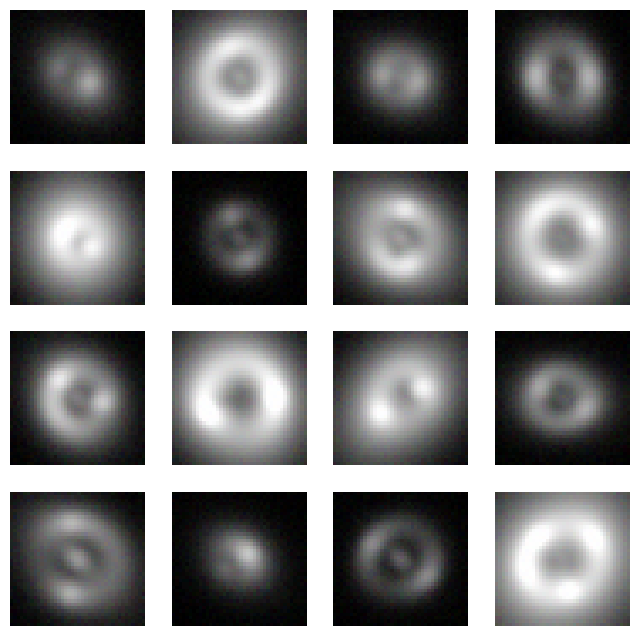

In [5]:
# Visualize source data
visualize_data(source_data)

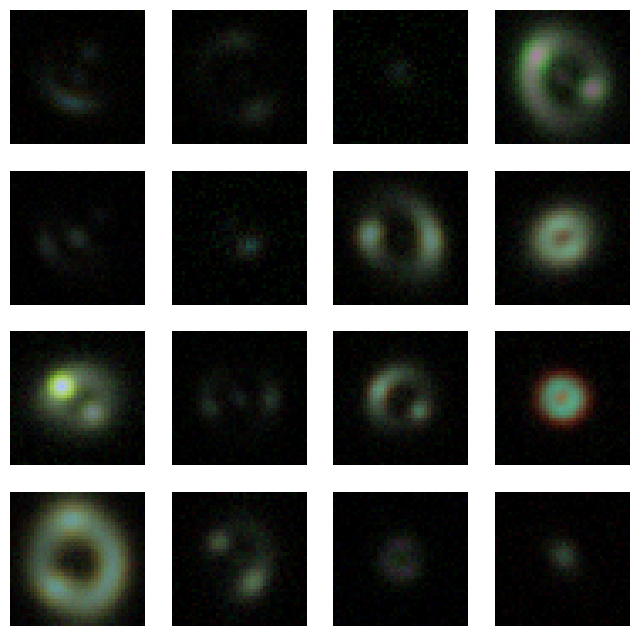

In [6]:
# Visualize target data
visualize_data(target_data)

In [7]:
# Define and initialize model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.feature = nn.Sequential()
        self.feature.add_module('f_conv1', nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding='same'))
        self.feature.add_module('f_relu1', nn.ReLU(True))
        self.feature.add_module('f_bn1', nn.BatchNorm2d(8))
        self.feature.add_module('f_pool1', nn.MaxPool2d(kernel_size=2, stride=2))
        self.feature.add_module('f_conv2', nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding='same'))
        self.feature.add_module('f_relu2', nn.ReLU(True))
        self.feature.add_module('f_bn2', nn.BatchNorm2d(16))
        self.feature.add_module('f_pool2', nn.MaxPool2d(kernel_size=2, stride=2))
        self.feature.add_module('f_conv3', nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding='same'))
        self.feature.add_module('f_relu3', nn.ReLU(True))
        self.feature.add_module('f_bn3', nn.BatchNorm2d(32))
        self.feature.add_module('f_pool3', nn.MaxPool2d(kernel_size=2, stride=2))

        self.regressor = nn.Sequential()
        self.regressor.add_module('r_fc1', nn.Linear(in_features=32*5*5, out_features=128))
        self.regressor.add_module('r_relu1', nn.ReLU(True))
        #self.regressor.add_module('r_fc2', nn.Linear(in_features=128, out_features=64))
        #self.regressor.add_module('r_relu2', nn.ReLU(True))
        self.regressor.add_module('r_fc3', nn.Linear(in_features=128, out_features=1))

    def forward(self, x):
        x = x.view(-1, 3, 40, 40)

        features = self.feature(x)
        features = features.view(-1, 32*5*5)
        estimate = self.regressor(features)
        estimate = F.relu(estimate)
        estimate = estimate.view(-1)

        return estimate, features


    def get_feature(self, x):
        x = x.view(-1, 3, 40, 40)
        features = self.feature(x)
        features = features.view(-1, 32*5*5)
        return features

In [8]:
# Code from https://github.com/ZongxianLee/MMD_Loss.Pytorch
# Comments by Shrihan Agarwal

class MMD_loss(nn.Module):
    """
    Calculate the MMD Loss using a Gaussian Kernel.
    MMD is the distance between the mean embeddings of the source/target dataset. 
    The distances are determined using a Gaussian kernel 
        k(x, y) ~ exp(-(x-y)^2 / (2 * sigma)).

    The bandwidth sigma is either input as fixed in `fix_sigma` or determined dynamically.
    One bandwidth is insufficient - small sigma leads to localization, and large leads to spread.
    Need to capture similarities at various scales.

    E.g. kernel_mul = 2, kernel_num = 5, fix_sigma = 1 creates:
    bandwidth_list = [1, 2, 4, 8, 16]

    Then uses pairwise kernel distances to compute MMD loss:
        Loss = Mean(source pairwise + target pairwise - source/target - target/source)
    
    """
    def __init__(self, kernel_mul = 2.0, kernel_num = 5):
        super(MMD_loss, self).__init__()
        self.kernel_num = kernel_num # Number of kernels to use
        self.kernel_mul = kernel_mul # How much to multiply the kernel by to get a new kernel
        self.fix_sigma = None
        return
        
    def gaussian_kernel(self, source, target, kernel_mul=2.0, kernel_num=5, fix_sigma=None):
        n_samples = int(source.size()[0])+int(target.size()[0])

        # Concatenate source and target catalogs along batch dimension
        # Source: (n, d), Target: (m, d), Total: (n + m, d)
        total = torch.cat([source, target], dim=0)

        # Replicate and calculate L2 distances between 
        # all samples, independent of source/target
        total0 = total.unsqueeze(0).expand(int(total.size(0)), int(total.size(0)), int(total.size(1)))
        total1 = total.unsqueeze(1).expand(int(total.size(0)), int(total.size(0)), int(total.size(1)))

        # L2 distance is of shape (n + m, n + m)
        L2_distance = ((total0-total1)**2).sum(2)
        
        if fix_sigma:
            bandwidth = fix_sigma
        else:
            bandwidth = torch.sum(L2_distance.data) / (n_samples**2-n_samples)
        bandwidth /= kernel_mul ** (kernel_num // 2)

        # Create bandwidth list as described
        bandwidth_list = [bandwidth * (kernel_mul**i) for i in range(kernel_num)]

        # Calculate kernel based distance using list of bandwidths and aggregate
        kernel_val = [torch.exp(-L2_distance / bandwidth_temp) for bandwidth_temp in bandwidth_list]

        # Return the kernel matrix which is of shape (n + m, n + m), summing over bandwidths
        return sum(kernel_val)

    def forward(self, source, target):
        batch_size = int(source.size()[0])
        kernels = self.gaussian_kernel(source, target, kernel_mul=self.kernel_mul, kernel_num=self.kernel_num, fix_sigma=self.fix_sigma)
        XX = kernels[:batch_size, :batch_size] # source pairwise kernel dists
        YY = kernels[batch_size:, batch_size:] # target pairwise kernel dists
        XY = kernels[:batch_size, batch_size:] # between source and target samples
        YX = kernels[batch_size:, :batch_size] # between source and target samples
        loss = torch.mean(XX + YY - XY - YX)    # definition of MMD loss
        return loss

In [9]:
# Define training loop
def train_loop(source_dataloader, 
               target_dataloader, 
               model, 
               regressor_loss_fn,
               da_loss,
               optimizer,
               n_epoch,
               epoch):
    """
    Trains the Neural Network on Source/Target Domains with the following loss:
        Loss = Source Regression Loss + 1.4 * DA MMD Loss
    
    source_dataloader: DataLoader for the source domain data.
	target_dataloader: DataLoader for the target domain data.
	model: The neural network model to be trained.
	regressor_loss_fn: Loss function for the regression task (e.g., MSELoss).
	da_loss: Loss function for domain adaptation (e.g., MMD loss).
	optimizer: Optimizer for the model parameters.
	n_epoch: Total number of epochs for training.
	epoch: Current epoch number.
    """

    domain_error = 0
    domain_classifier_accuracy = 0
    estimator_error = 0
    score_list = np.array([])

    # Iteration length is shorter of the two datasets
    len_dataloader = min(len(source_dataloader), len(target_dataloader))
    data_source_iter = iter(source_dataloader)
    data_target_iter = iter(target_dataloader)

    # Iterate over the two datasets
    i = 0
    while i < len_dataloader:

        # Time-varying hyperparameter, p 0 -> infty, alpha 0 -> 1
        p = float(i + epoch * len_dataloader) / n_epoch / len_dataloader # UNUSED
        alpha = 2. / (1. + np.exp(-10 * p)) - 1 # UNUSED

        # Source Training

        # Load a batch of source data, move to GPU
        data_source = next(data_source_iter)
        X, y = data_source
        X = X.float()
        X = X.cuda()
        y = y.cuda()

        # Zero model gradients and labels
        model.zero_grad()
        batch_size = len(y)

        domain_label = torch.zeros(batch_size)
        domain_label = domain_label.long()
        domain_label = domain_label.cuda()

        # Apply data to model and get predictions, embeddings, apply gradients
        estimate_output, domain_output_source = model(X)

        # Calculate source regression loss based on predictions
        estimate_loss = regressor_loss_fn(estimate_output, y)

        # Target Training

        data_target = next(data_target_iter)
        X_target, _ = data_target
        X_target = X_target.float()
        X_target = X_target.cuda()

        batch_size = len(X_target)

        _, domain_output_target = model(X_target)

        # Calculate the DA Loss between source and target, MMD loss
        domain_loss = da_loss(domain_output_source, domain_output_target)

        # Hyperparameter of 1.4 set to weight domain loss vs source loss
        # Perhaps this is where alpha was initially used
        loss = estimate_loss + domain_loss*1.4

        # Backpropagation, update optimizer lr
        loss.backward()
        optimizer.step()

        # Update values
        
        # Domain loss is the DA loss or MMD loss between embedding outputs
        domain_error += domain_loss.item()

        # Estimator loss is the source data loss on regression
        estimator_error += estimate_loss.item()

        # Calculate the R2 score of the predictions vs. labels
        score = r2_score(y.cpu().detach().numpy(), estimate_output.cpu().detach().numpy())
        score_list = np.append(score_list, score)

        i += 1

    # Calculate average scores/errors of batches for this epoch
    score = np.mean(score_list)
    domain_error = domain_error / (len_dataloader)
    estimator_error /= len_dataloader

    return [domain_error, estimator_error, score]

In [10]:
# Define testing loop

def test_loop(source_dataloader, 
              target_dataloader, 
              model, 
              regressor_loss_fn, 
              da_loss, 
              n_epoch, 
              epoch):
    """
    Tests the model accuracy.
    
    source_dataloader: DataLoader for the source domain data.
	target_dataloader: DataLoader for the target domain data.
	model: The neural network model to be trained.
	regressor_loss_fn: Loss function for the regression task (e.g., MSELoss).
	da_loss: Loss function for domain adaptation (e.g., MMD loss). UNUSED
	n_epoch: Total number of epochs for training.
	epoch: Current epoch number.
    """

    
    # Evaluating without gradient computation in bg for validation
    with torch.no_grad():
        
        len_dataloader = min(len(source_dataloader), len(target_dataloader))
        data_source_iter = iter(source_dataloader)
        data_target_iter = iter(target_dataloader)

        
        domain_classifier_error = 0
        domain_classifier_accuracy = 0
        estimator_error = 0
        estimator_error_target = 0
        score_list = np.array([])
        score_list_target = np.array([])

        i = 0
        while i < len_dataloader:

            p = float(i + epoch * len_dataloader) / n_epoch / len_dataloader
            alpha = 2. / (1. + np.exp(-10 * p)) - 1

            # Source Testing

            data_source = next(data_source_iter)
            X, y = data_source
            X = X.float()
            X = X.cuda()
            y = y.cuda()

            batch_size = len(y)

            estimate_output, domain_output = model(X)

            estimate_loss = regressor_loss_fn(estimate_output, y)

            # Target Testing

            data_target = next(data_target_iter)
            X_target, y_target = data_target
            X_target = X_target.float()
            X_target = X_target.cuda()
            y_target = y_target.cuda()

            batch_size = len(X_target)

            estimate_output_target, domain_output = model(X_target)

            estimate_loss_target = regressor_loss_fn(estimate_output_target, y_target)

            # Update values

            # Regression loss on validation testing
            estimator_error += estimate_loss.item()
            estimator_error_target += estimate_loss_target.item()

            # R2 Scores on validation testing
            score = r2_score(y.cpu(), estimate_output.cpu())
            score_list = np.append(score_list, score)
            score_target = r2_score(y_target.cpu(), estimate_output_target.cpu())
            score_list_target = np.append(score_list_target, score_target)

            i += 1

        score = np.mean(score_list)
        score_target = np.mean(score_list_target)
        estimator_error /= len_dataloader
        estimator_error_target /= len_dataloader
        
    classifier_error = 1
    return [classifier_error, estimator_error, estimator_error_target, score, score_target]

In [11]:
# Initialize dictionary for training stats
import time
model = NeuralNetwork().cuda()
# Hyper parameter presets
learning_rate = 6e-5
epochs = 30
# Define loss functions and optimizer
regressor_loss_fn = nn.MSELoss().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
da_loss = MMD_loss()

In [12]:
def print_epoch_scores(stats, epoch, t):
    """ Prints all relevant scores for each epoch. """
    train_stats = [i for i in stats.keys() if "train" in i]
    val_stats = [i for i in stats.keys() if "val" in i]
    fmt = lambda k: " ".join([i.capitalize() for i in k.split('_')]) + ": "
    
    print("\nEpoch {0}: {1:.2f}s".format(epoch, t) + "\n-------------------------------")
    print(" Training Statistics:")
    for s in train_stats:
        print("\t" + fmt(s) + ": {:.4f}".format(stats[s][-1]))
    print(" Validation Statistics:")
    for s in val_stats:
        print("\t" + fmt(s) + ": {:.4f}".format(stats[s][-1]))

stats = {'train_DA_loss':[],
             'train_regression_loss':[],
             'train_r2_score':[],
             'val_source_regression_loss':[],
             'val_target_regression_loss':[],
             'val_source_r2_score':[],
             'val_target_r2_score':[]}

print("Beginning Training...")
# Train
for i in range(epochs):
        start_time = time.time()
        vals = train_loop(source_train_dataloader, target_train_dataloader, model,
                   regressor_loss_fn, da_loss, optimizer, epochs, i)

        vals_validate = test_loop(source_val_dataloader, target_val_dataloader,
                         model, regressor_loss_fn, da_loss, epochs, i)

        stats['train_DA_loss'].append(vals[0])
        stats['train_regression_loss'].append(vals[1])
        stats['train_r2_score'].append(vals[2])
        stats['val_source_regression_loss'].append(vals_validate[1])
        stats['val_target_regression_loss'].append(vals_validate[2])
        stats['val_source_r2_score'].append(vals_validate[3])
        stats['val_target_r2_score'].append(vals_validate[4])

        print_epoch_scores(stats, i, time.time() - start_time)
        

torch.save(model.state_dict(), "models/mb_isomap_jul18_1pm")

In [13]:
model.load_state_dict(torch.load("models/mb_isomap_jul18_1pm"))

<All keys matched successfully>

In [14]:
def generate_isomaps(source_data, target_data, n_neighbors = 5, n_components = 2, n_points = 1000):
    """
    * AI-Generated Docstring *
    Generates Isomap embeddings for source and target data, both raw and feature-transformed.

    This function performs the following steps:
    1. Collects garbage and empties the CUDA cache to free up memory.
    2. Initializes two Isomap models with the specified number of neighbors and components: one for raw data and one for feature-transformed data.
    3. Reshapes the source and target data to 2D arrays and limits the number of points.
    4. Fits the first Isomap model to the raw source and target data.
    5. Transforms the source and target data into tensors and passes them through a neural network model to get feature embeddings.
    6. Fits the second Isomap model to the feature embeddings and transforms them into 2D embeddings.
    7. Transforms the original source and target data into 2D embeddings using the first Isomap model.

    Args:
        source_data (np.ndarray): The source data array.
        target_data (np.ndarray): The target data array.
        n_neighbors (int, optional): The number of neighbors to consider for each point in Isomap. Default is 5.
        n_components (int, optional): The number of dimensions to reduce to. Default is 2.
        n_points (int, optional): The number of points to use from the source and target data. Default is 1000.

    Returns:
        tuple: Four arrays containing the 2D Isomap embeddings:
            - source_iso (np.ndarray): 2D Isomap embeddings of the raw source data.
            - target_iso (np.ndarray): 2D Isomap embeddings of the raw target data.
            - trained_source_iso (np.ndarray): 2D Isomap embeddings of the feature-transformed source data.
            - trained_target_iso (np.ndarray): 2D Isomap embeddings of the feature-transformed target data.
    """
    gc.collect()
    torch.cuda.empty_cache()
    
    isomap = Isomap(n_neighbors=n_neighbors, n_components=n_components)
    train_isomap = Isomap(n_neighbors=n_neighbors, n_components=n_components)
    
    sdata = source_data.reshape([-1, np.prod(source_data.shape[1:])])[:n_points]
    tdata = target_data.reshape([-1, np.prod(target_data.shape[1:])])[:n_points]
    isomap = isomap.fit(sdata)
    isomap = isomap.fit(tdata)
    
    with torch.no_grad():
        source_tensor = torch.FloatTensor(source_data[:n_points]).to(device)
        target_tensor = torch.FloatTensor(target_data[:n_points]).to(device)
        sfeat = model.get_feature(source_tensor).cpu().detach().numpy()
        tfeat = model.get_feature(target_tensor).cpu().detach().numpy()
        
    train_isomap = train_isomap.fit(sfeat)
    train_isomap = train_isomap.fit(tfeat)
    trained_source_iso = train_isomap.transform(sfeat)
    trained_target_iso = train_isomap.transform(tfeat)
    
    del sfeat
    del tfeat
    
    source_iso = isomap.transform(sdata)
    target_iso = isomap.transform(tdata)

    return source_iso, target_iso, trained_source_iso, trained_target_iso

In [15]:
source_iso, target_iso, trained_source_iso, trained_target_iso = generate_isomaps(source_data, target_data)

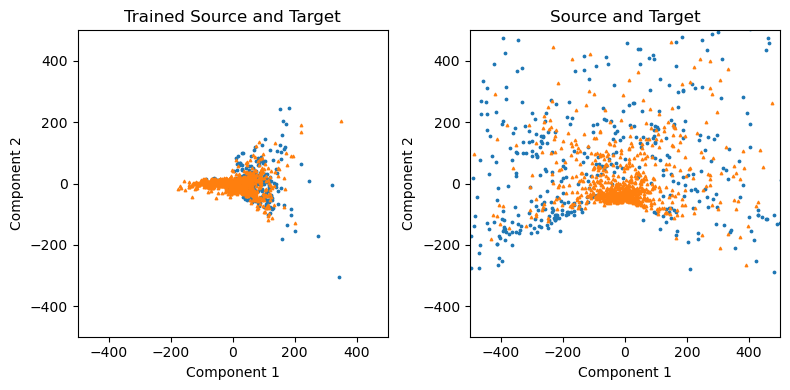

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

ax1.scatter(trained_source_iso[:, 0], trained_source_iso[:, 1], s=3, marker='o')
ax1.scatter(trained_target_iso[:, 0], trained_target_iso[:, 1], s=3, marker='^')
lval1 = 500
ax1.set_xlim(-lval1, lval1)
ax1.set_ylim(-lval1, lval1)
ax1.set_title('Trained Source and Target')

ax2.scatter(source_iso[:, 0], source_iso[:, 1], s=3, marker='o')
ax2.scatter(target_iso[:, 0], target_iso[:, 1], s=3, marker='^')
lval2 = 500
ax2.set_xlim(-lval2, lval2)
ax2.set_ylim(-lval2, lval2)
ax2.set_title('Source and Target')

ax1.set_xlabel('Component 1')
ax1.set_ylabel('Component 2')
ax2.set_xlabel('Component 1')
ax2.set_ylabel('Component 2')

plt.tight_layout()
plt.show()

In [34]:
source_labels = pd.read_csv(source_meta)['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'].tolist()[:1000]
target_labels = pd.read_csv(target_meta)['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'].tolist()[:1000]

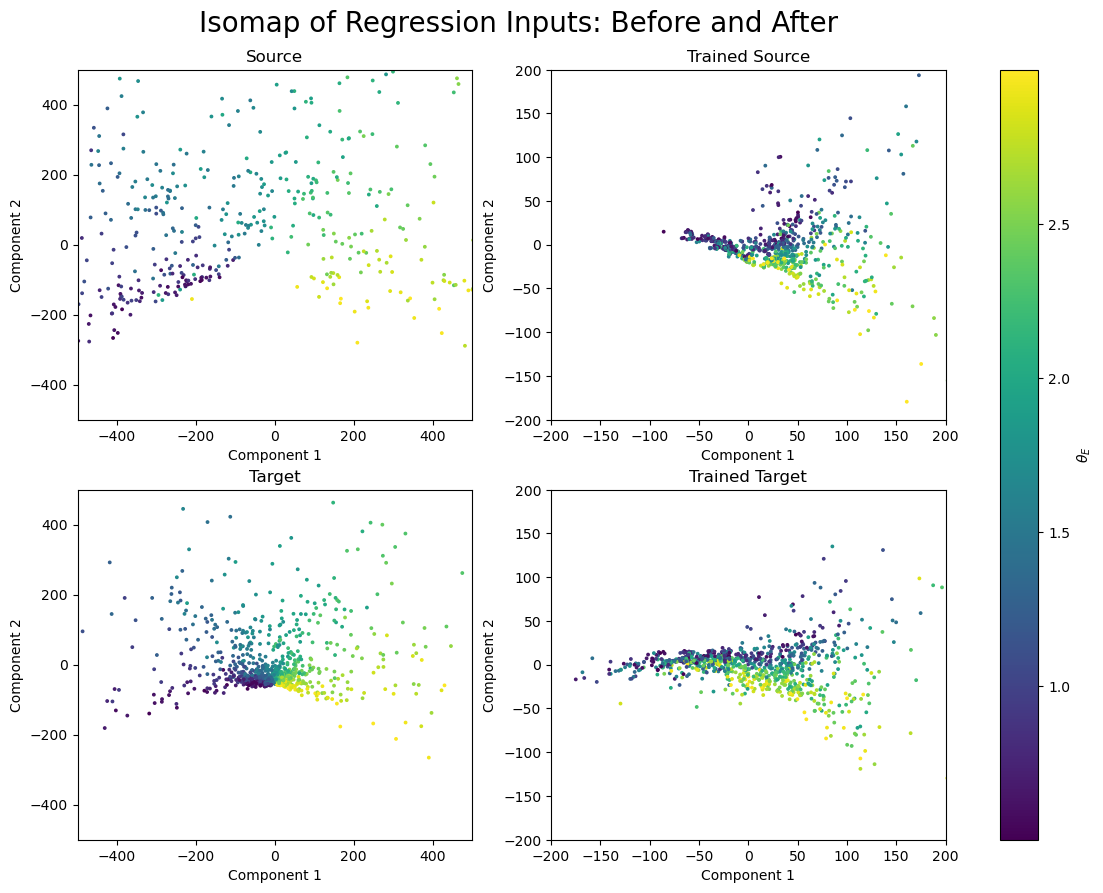

In [52]:
fig, ax = plt.subplots(2, 2, figsize=(14, 10))

ax1 = ax[0][1]
scatter1 = ax1.scatter(trained_source_iso[:, 0], trained_source_iso[:, 1], s=3, marker='o', c = source_labels)
lval1 = 200
ax1.set_xlim(-lval1, lval1)
ax1.set_ylim(-lval1, lval1)
ax1.set_title('Trained Source')

ax2 = ax[0][0]
ax2.scatter(source_iso[:, 0], source_iso[:, 1], s=3, c = source_labels)
lval2 = 500
ax2.set_xlim(-lval2, lval2)
ax2.set_ylim(-lval2, lval2)
ax2.set_title('Source')

ax1 = ax[1][1]
ax1.scatter(trained_target_iso[:, 0], trained_target_iso[:, 1], s=3, marker='o', c = target_labels)
lval1 = 200
ax1.set_xlim(-lval1, lval1)
ax1.set_ylim(-lval1, lval1)
ax1.set_title('Trained Target')

ax2 = ax[1][0]
ax2.scatter(target_iso[:, 0], target_iso[:, 1], s=3, c = target_labels)
lval2 = 500
ax2.set_xlim(-lval2, lval2)
ax2.set_ylim(-lval2, lval2)
ax2.set_title('Target')

for i in ax.ravel():
    i.set_xlabel('Component 1')
    i.set_ylabel('Component 2')

cbar = fig.colorbar(scatter1, ax=ax.ravel().tolist(), orientation='vertical')
cbar.set_label('$\\theta_E$')

plt.suptitle("Isomap of Regression Inputs: Before and After", x = 0.44, y = 0.94, fontsize = 20)
plt.show()

In [ ]:
def get_feature(self, x):
    x = x.view(-1, 3, 40, 40)
    features = self.feature(x)
    features = features.view(-1, 32*5*5)
    return features

In [139]:
'train_DA_loss':[],
             'train_regression_loss':[],
             'train_r2_score':[],
             'val_source_regression_loss':[],
             'val_target_regression_loss':[],
             'val_source_r2_score':[],
             'val_target_r2_score':[]}

SyntaxError: illegal target for annotation (2919055091.py, line 1)

In [ ]:
# Classifier
eps = np.arange(epochs)
plt.title("DA Loss Error")
plt.plot(eps, stats['train_DA_loss'])

In [ ]:
# Estimator
plt.title("Estimator Error")
plt.plot(eps, stats['train_estimator_error'])
plt.plot(eps, stats['val_estimator_error'])
plt.plot(eps, stats['val_estimator_error_target'])

In [ ]:
# R2 Scores
plt.title("R2 Scores")
plt.plot(eps, stats['train_score'])
plt.plot(eps, stats['val_score'])
plt.plot(eps, stats['val_score_target'])

Source R2 Score is 0.9778


Text(0.5, 1.0, 'MMD | Source | R2: 0.978')

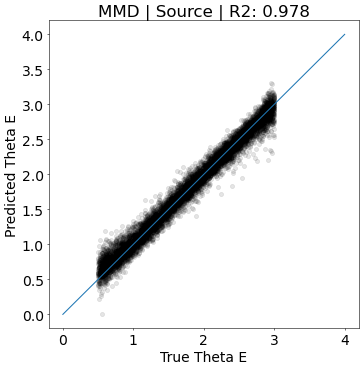

In [43]:
# Test Source
preds = np.array([])
true = np.array([])
score_list = np.array([])

with torch.no_grad():
    for X, y in source_test_dataloader:
        X = X.float()
        pred, _ = model(X.cuda())
        preds = np.append(preds, pred.cpu())
        true = np.append(true, y.cpu())
        score = r2_score(y.cpu(), pred.cpu())
        score_list = np.append(score_list, score)

score = np.mean(score_list)
print(f'Source R2 Score is {score:.4f}')

plt.figure(figsize=(8,8),dpi=50)
plt.scatter(true, preds,  color='black', alpha = 0.1)
line = np.linspace(0, 4, 100)
plt.plot(line, line)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Predicted Theta E');
plt.rc('font', size=20)
plt.title('MMD | Source | R2: {0:.3f}'.format(score))

Target R2 Score is 0.9597


Text(0.5, 1.0, 'MMD | Target | R2: 0.960')

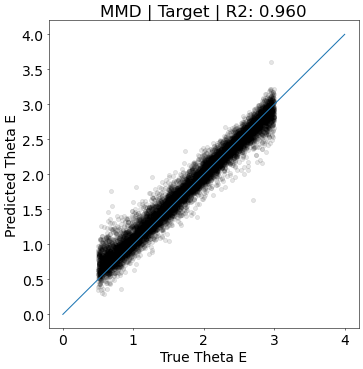

In [44]:
# Test target
preds = np.array([])
true = np.array([])
score_list = np.array([])

with torch.no_grad():
    for X, y in target_test_dataloader:
        X = X.float()
        pred, _ = model(X.cuda())
        preds = np.append(preds, pred.cpu())
        true = np.append(true, y.cpu())
        score = r2_score(y.cpu(), pred.cpu())
        score_list = np.append(score_list, score)

score = np.mean(score_list)
print(f'Target R2 Score is {score:.4f}')

plt.figure(figsize=(8,8),dpi=50)
plt.scatter(true, preds,  color='black', alpha = 0.1)
line = np.linspace(0, 4, 100)
plt.plot(line, line)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Predicted Theta E');
plt.rc('font', size=20)
plt.title('MMD | Target | R2: {0:.3f}'.format(score))